# <center> Basic epidemic models

## Helpers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def peak(L):
    for i in range(len(L)):
        if L[i+1]<L[i]:
            return i
    return "no peak"

## SIR model

In this first approach, we consider three types of people:

- the __susceptible__ people: they are not immune thus they are likely to be infected
- the __infected__ people: they carry the virus and can infect the susceptible people
- the __recovered__ people: they've already been infected and then they recovered or died. Either case, they can't get infected anymore.

The ODE that we need to solve are as follow:

$$
\left\{
\begin{array}{r c l}
S'(t) & = & -pS(t)I(t) \\
I'(t) & = & pS(t)I(t) - I(t)/d \\
R'(t) & = & I(t)/d
\end{array}
\right.
$$

Where:

- *p* is the __infection rate__: depends on the number of contact between infected and susceptible people, and the probability for a contact to be contagious.
- *d* is the __contagiousness duration__: the number of days people stay contagious.

In [73]:
def SIR(I0, rho, c, d, T):
    p = rho*c # Infection rate
    S, I, R = 1-I0, I0, 0
    S_list, I_list, R_list = [S], [I], [R]
    for i in range(T):
        S, I, R = S - p*S*I, I + p*S*I - I/d, R + I/d
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
    return S_list, I_list, R_list

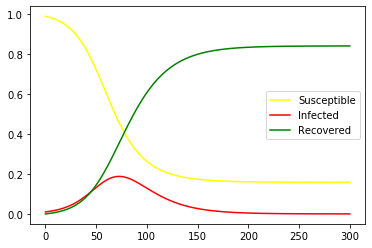

Cumulative number of infected people: 84.1%
Duration before the peak: 73


In [75]:
I0 = .01 # Initial number of infected people
rho = .04 # Probabibility of contagion for an interaction
c = 3 # Number of contacts per people per day
d = 18 # Contagiousness duration (days) 
T = 300 # Study duration (days)

S_list, I_list, R_list = SIR(I0, rho, c, d, T)

plt.plot(S_list, label='Susceptible', color='yellow')
plt.plot(I_list, label='Infected', color='red')
plt.plot(R_list, label='Recovered', color='green')
plt.legend()
plt.show()

print("Cumulative number of infected people: {}%".format(round(100*R_list[-1], 1)))
print("Duration before the peak: {}".format(peak(I_list)))

## SEIR model

In this second approach, we consider three types of people:

- the __susceptible__ people: they are not immune thus they are likely to be infected
- the __exposed__ people: they carry the virus but they don't have any symptoms
- the __infected__ people: they carry the virus and can infect the susceptible people, but they know thay are sick as they are enough advanced to have symptoms
- the __recovered__ people: they've already been infected and then they recovered or died. Either case, they can't get infected anymore.

The ODE that we need to solve are as follow:

$$
\left\{
\begin{array}{r c l}
S'(t) & = & -p_eS(t)E(t) - p_iS(t)I(t) \\
E'(t) & = & p_eS(t)E(t) + p_iS(t)I(t) - E(t)/d_e \\
I'(t) & = & E(t)/d_e - I(t)/d_i \\
R'(t) & = & I(t)/d_i
\end{array}
\right.
$$

Where:

- $p_e$ is the __exposition rate__: depends on the number of contact between exposed and susceptible people, and the probability for a contact to be contagious.
- $p_i$ is the __infection rate__: depends on the number of contact between infected and susceptible people, and the probability for a contact to be contagious.
- $d_e$ is the __exposition duration__: the number of days people stay contagious without any symptom.
- $d_i$ is the __infection duration__: the number of days people stay contagious with symptoms.

In [3]:
def SEIR(E0, I0, rho_e, rho_i, c_e, c_i, de, di, T):
    pe = rho_e*c_e # Exposition rate
    pi = rho_i*c_i # Infection rate
    S, E, I, R = 1-E0-I0, E0, I0, 0
    S_list, E_list, I_list, R_list = [S], [E], [I], [R]
    for i in range(T):
        S, E, I, R = S - pe*S*E - pi*S*I, E + pe*S*E + pi*S*I - E/de, I + E/de - I/di, R + I/di
        S_list.append(S)
        E_list.append(E)
        I_list.append(I)
        R_list.append(R)
    return S_list, E_list, I_list, R_list

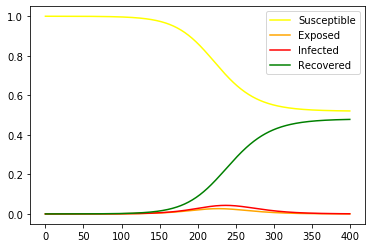

Cumulative number of infected people: 0.47809741537306305
Duration before the peak: 237


In [4]:
E0 = .000015 # Initial number of exposed people
I0 = .00001 # Initial number of infected people
rho_e = .04 # Probabibility of contagion for an interaction
rho_i = .04 # Probabibility of contagion for an interaction
c_e = 4 # Number of contacts per people per day
c_i = 1 # Number of contacts per people per day
de = 6 # Exposition duration (days)
di = 10 # Infection duration (days)
T = 400 # Study duration (days)

S_list, E_list, I_list, R_list = SEIR(E0, I0, rho_e, rho_i, c_e, c_i, de, di, T)

plt.plot(S_list, label='Susceptible', color='yellow')
plt.plot(E_list, label='Exposed', color='orange')
plt.plot(I_list, label='Infected', color='red')
plt.plot(R_list, label='Recovered', color='green')
plt.legend()
plt.show()

print("Cumulative number of infected people: {}".format(R_list[-1]))
print("Duration before the peak: {}".format(peak(I_list)))

## Fitting SEIR model to Novel data (Kaggle)

In this part we will try to fit the SEIR model to some real data found on kaggle.com. The parameters we need to fit are $p_e$ and $p_i$. Recall that the SEIR model doesn't directly consider $p_e$ and $p_i$. Its inputs are $\rho_e$, $c_e$, $\rho_i$ and $c_i$. The formulae that links all these parameters are:
$$
\left\{
\begin{array}{r c l}
p_e & = & \rho_ec_e \\
p_i & = & \rho_ic_i
\end{array}
\right.
$$

The most reliable data we have is the evolution of I(t). We have pulled out the evolution of the number of infected people in France between 03/15 and 04/01. The series is called $I_{ref}$ (*cf.* 3 cells below). At each optimization step, the SEIR model is simulated and returns $I_{list}$. Then we can compute the cost function $J(I_{list}, I_{ref})=\frac{||I_{list}-I_{ref}||_{L^2}}{||I_{ref}||_{L^2}}$.

The optimization method is a simple gridsearch. 

We can use some regularization methods, to avoid too high coefficients $p_e$ and $p_i$.

In [5]:
def J(I_ref, rho_e, rho_i, c_e, c_i, regularization_methods=None, T=200):
    
    I0, E0 = I_ref[0], 1.5*I_ref[0]
    if 'tikhonov' in regularization_methods or 'max' in regularization_methods:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, rho_e, rho_i, c_e, c_i, 6, 10, T)
    else:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, rho_e, rho_i, c_e, c_i, 6, 10, len(I_ref)-1)
    I_list = np.array(I_list)
    err = np.linalg.norm(I_ref-I_list[:len(I_ref)])/np.linalg.norm(I_ref)
    
    reg = 0
    if 'p_e' in regularization_methods:
        reg += regularization_methods['p_e']*rho_e*c_e
    if 'p_i' in regularization_methods:
        reg += regularization_methods['p_i']*rho_i*c_i
    if 'max' in regularization_methods:
        reg += regularization_methods['max']*np.max(I_list)
    if 'tikhonov' in regularization_methods:
        reg += regularization_methods['tikhonov']*np.linalg.norm(I_list)
    
    return err + reg
    

In [6]:
def grid_search(I_ref, grid_rho_e, grid_rho_i, grid_c_e, grid_c_i, regularization_methods=None, T=200):
    best_J = float('inf') 
    for rho_e in grid_rho_e:
        for rho_i in grid_rho_i:
            for c_e in grid_c_e:
                for c_i in grid_c_i:
                    new_J = J(I_ref, rho_e, rho_i, c_e, c_i, regularization_methods, T)
                    if new_J < best_J:
                        best_J = new_J
                        best_rho_e, best_rho_i, best_c_e, best_c_i = rho_e, rho_i, c_e, c_i
    return best_rho_e, best_rho_i, best_c_e, best_c_i, best_J

/opt/miniconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
/opt/miniconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


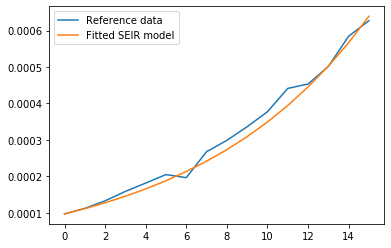

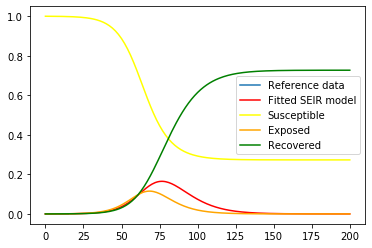

In [18]:
# Novel data (https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv)
I_ref = np.array([
    9.66119E-05,
    0.000111821,
    0.000132582,
    0.000158448,
    0.000181343,
    0.000204597,
    0.000196179,
    0.000267507,
    0.000298537,
    0.000335985,
    0.000377149,
    0.000441209,
    0.000453224,
    0.000501478,
    0.000584493,
    0.000627209
])

# Grid search parameters
n_grid = 20
grid_rho_e = np.linspace(0, 1, n_grid)
grid_rho_i = np.linspace(0, 1, n_grid)
grid_c_e = np.linspace(.1, 10, n_grid)
grid_c_i = np.linspace(.1, 10, n_grid)

# Regularization parameters
T = 200
regularization_methods = {
    'p_e': 1,
    'p_i': 1,
    'max': 0,
    'tikhonov': 0
}
    
best_rho_e, best_rho_i, best_c_e, best_c_i, best_J = grid_search(I_ref, grid_rho_e, grid_rho_i, grid_c_e, grid_c_i, regularization_methods, T) 

# Fitted model
S_list, E_list, I_list, R_list = SEIR(1.5*I_ref[0], I_ref[0], best_rho_e, best_rho_i, best_c_e, best_c_i, 6, 10, T)

In [ ]:
# Plot result
plt.plot(I_ref, linestyle='None', marker='x', c='blue', label='I(t) (reference data)')
plt.plot(I_list[:len(I_ref)], c='red', label='I(t) (fitted SEIR model)')
plt.legend()
plt.show()
plt.plot(I_ref, linestyle='None', marker='x', label='I(t) (reference data)')
plt.plot(I_list, c='red', label='I(t) (fitted SEIR model)')
plt.plot(S_list, c='yellow', label='S(t) (fitted SEIR model)')
plt.plot(E_list, c='orange', label='E(t) (fitted SEIR model)')
plt.plot(R_list, c='green', label='R(t) (fitted SEIR model)')
plt.legend()
plt.show()